**Goal:**

The purpose of this code is to find the optimal hyperparameters for a model, representing the early stage of a pipeline. These optimal hyperparameters identified will be then used to train the model. For simplicity and demonstration purposes, this code uses a simple dense model and performs random search for hyperparameter tuning, as described in Rampal et al. (2022). It can easily be adapted for grid search as well.

**Steps:**

**Preparation:** Import necessary packages and libraries, and define the training, testing, and validation datasets.

**Define the model and hyperparameter space:** A function is created to specify the search space for individual hyperparameters and to define the simple dense model. Four hyperparameters are considered: learning rate, dense layers, dropout rate, and batch size. In this case, using daily precipitation data, the batch size corresponds to the number of days. For example, in a dataset with 300 days and a batch size of 100, there will be 3 batches. Each batch will update the weights and MSE, with the MSE at a given epoch being the average across all batches. By default, batches are selected randomly unless shuffling is disabled.

**Perform random search:** The code was run with 10 and 20 trials, where each trial represents a different combination of hyperparameter values. Running different numbers of trials can yield slightly different optimal hyperparameters. Each trial runs for the assigned number of epochs (25 in this case) and records the average MSE using the validation dataset. Throughout the trials, the hyperparameter setup that produces the lowest validation MSE is saved as the optimal configuration. Note that the initial run may take longer since all trials are executed, but results are saved to a folder for reuse to reduce time in future runs.

**Evaluate model performance:** The code generates a learning curve, plotting MSE as a function of the number of epochs for both the training and validation datasets. The plot shows that the validation MSE stabilizes after 5 epochs, indicating the optimal number of epochs. If the validation MSE stabilizes while the training MSE continues to decline, it suggests a risk of overfitting when using larger epoch numbers.

**Future Work:**


*   This code does not yet account for the relative importance of hyperparameters, which could be prioritized in future tuning efforts.
*   The hyperparameter tuning process can be expanded to include more complex models, such as CNNs.
*   Shuffling is enabled during batch selection, which disrupts the temporal dependencies in precipitation data. Investigating the impact of shuffling on model performance could be an area of exploration.

In [ ]:
### import needed packages
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt  # Import the tuner from TensorFlow Keras


2024-10-12 01:42:00.419373: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 01:42:00.421864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 01:42:00.463552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-12 01:42:00.464282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 01:42:02.749633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.13.1


In [ ]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import sys
import tensorflow.keras.backend as K

# my working paths
sys.path.append(r'/home/u1281808/High-res-interpretable-dl/src')
# change to the directory of the "src file"
os.chdir(r'/home/u1281808/High-res-interpretable-dl')

from dask.diagnostics import ProgressBar
import cmocean
from models import train_model, complex_conv, simple_conv, predict, simple_dense, linear_complex_model
from losses import gamma_loss_1d, gamma_mse_metric
from prepare_data import format_features, prepare_training_dataset, create_test_train_split

tf.random.set_seed(2)

In [ ]:
# select the input and output data, following Rampal et al. (2022)
config = dict(y = "/home/u1281808/High-res-interpretable-dl/training_data/topography_subset_full.nc",
              X = "/home/u1281808/High-res-interpretable-dl/training_data/ERA5_training_dataset_6_3_23_bilinear_half_degree.nc",
              train_start = "1982-01-01",
              train_end = "2005-01-01",
              val_start = "2005-02-01",
              val_end = "2010-01-01",
              test_start = "2010-01-01",
              test_end = "2018-12-01",
              downscale_variables = ['w_850', 'u_850', 'v_850', 'q_850', 't_850'])

x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(x_train, x_val, x_test, y_train, y_val, y_test)

### modify the original code by yhw
# Ensure y_train, y_val, and y_test datasets have consistent type with x
y_train_var = y_train['pr']
y_val_var = y_val['pr']
y_test_var = y_test['pr']

# Convert x_train, y_train_var, x_val, y_val_var, x_test, and y_test_var to NumPy arrays
x_train_np = x_train.values
y_train_np = y_train_var.values  # y_train_var is now an xarray.DataArray
x_val_np = x_val.values
y_val_np = y_val_var.values
x_test_np = x_test.values
y_test_np = y_test_var.values

input_shape = x_train_np.shape[1:]  # Use the NumPy array shape for input
output_shape = y_train_np.shape[1]  # Assuming the second dimension represents the output shape, modify if needed

[########################################] | 100% Completed | 6.06 ss
[########################################] | 100% Completed | 507.13 ms
[########################################] | 100% Completed | 2.02 ss
[########################################] | 100% Completed | 204.70 ms
[########################################] | 100% Completed | 826.90 ms
[########################################] | 100% Completed | 101.54 ms


In [ ]:
# Define a model-building function for the simple_dense model
# using different combinations of four hyperparameters
def build_simple_dense_model(hp):
    # Tune the number of neurons in the dense layers
    dense_layers = hp.Choice('dense_layers', values=[64, 128, 256, 512])

    # Tune the dropout rate between 0.1 and 0.7
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.7, step=0.1)

    # Tune the learning rate from a list of choices
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

    # Tune the batch size, number of days in daily precipitation selected from the training data
    batch_size = hp.Choice('batch_size', values=[32, 64, 128])

    # Create the simple_dense model with randomly sampled hyperparameters
    model = simple_dense(
        dense_layers=[dense_layers, output_shape],
        dense_activation='selu',
        input_shape=input_shape,
        dropout=dropout_rate
    )

    # Compile the model with the randomly selected learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mse'])

    return model

# Instantiate the tuner and perform a random search
tuner = kt.RandomSearch(
    build_simple_dense_model,
    objective='val_mse',
    # test between 10 and 20
    max_trials = 20,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='hyperparameter_tuning',  # Directory to save results
    project_name='simple_dense_tuning'
)

# Define search space for hyperparameter tuning
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_layers (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}


2024-10-12 01:42:40.756261: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-12 01:42:40.770195: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Trial 20 Complete [00h 01m 35s]
val_mse: 37.849884033203125

Best val_mse So Far: 35.63283920288086
Total elapsed time: 00h 51m 43s

The optimal number of dense layers is 512 and
the optimal dropout rate is 0.1 with a learning rate of 0.0001.


The optimal batch size is 32

Epoch 1/25
263/263 [==============================] - 13s 48ms/step - loss: 69.6701 - mse: 69.6701 - val_loss: 51.8776 - val_mse: 51.8776
Epoch 2/25
263/263 [==============================] - 12s 46ms/step - loss: 52.9824 - mse: 52.9824 - val_loss: 46.5252 - val_mse: 46.5252
Epoch 3/25
263/263 [==============================] - 12s 46ms/step - loss: 47.7063 - mse: 47.7063 - val_loss: 43.7405 - val_mse: 43.7405
Epoch 4/25
263/263 [==============================] - 12s 46ms/step - loss: 44.4134 - mse: 44.4134 - val_loss: 42.3168 - val_mse: 42.3168
Epoch 5/25
263/263 [==============================] - 12s 46ms/step - loss: 41.9907 - mse: 41.9907 - val_loss: 40.6211 - val_mse: 40.6211
Epoch 6/25
263/263 [===============

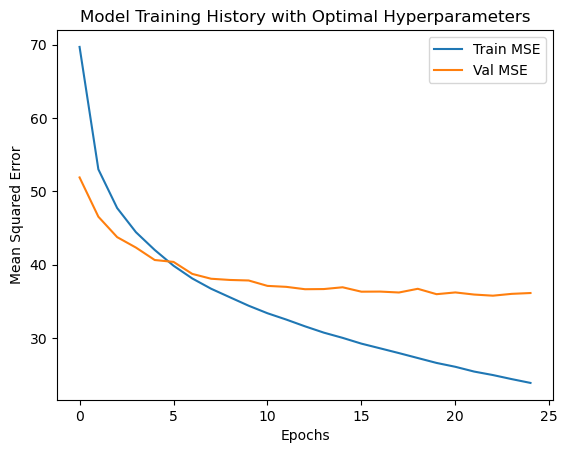

In [ ]:
# Perform the search
tuner.search(x_train_np, y_train_np, epochs = 25, validation_data=(x_val_np, y_val_np))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of dense layers is {best_hps.get('dense_layers')} and
the optimal dropout rate is {best_hps.get('dropout_rate')} with a learning rate of {best_hps.get('learning_rate')}.
""")

# Extract the best batch size for training
best_batch_size = best_hps.get('batch_size')
print(f"""
The optimal batch size is {best_batch_size}
""")

# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_np, y_train_np, epochs = 25, validation_data=(x_val_np, y_val_np))

# Evaluate the model on test data
test_loss, test_mse = model.evaluate(x_test_np, y_test_np)
print(f"Test MSE: {test_mse}")

# Create a figure object
fig = plt.figure()

# Visualize the model performance (training vs. validation)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Model Training History with Optimal Hyperparameters')
plt.legend()
plt.show()

fig.savefig('hyperparmeter_tuning_simpledense_mse_trail20.png', dpi=300)
